# 1. Loading the Dataset

In [4]:
import pandas as pd

data = pd.read_csv("Final_data.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Person             978 non-null    object 
 1   Wav file           978 non-null    object 
 2   MDVP:Fo(Hz)        978 non-null    float64
 3   MDVP:Fhi(Hz)       978 non-null    float64
 4   MDVP:Flo(Hz)       978 non-null    float64
 5   MDVP:Jitter(%)     978 non-null    float64
 6   MDVP:Jitter(Abs)   978 non-null    float64
 7   MDVP:RAP           978 non-null    float64
 8   MDVP:PPQ           978 non-null    float64
 9   Jitter:DDP         978 non-null    float64
 10  MDVP:Shimmer       978 non-null    float64
 11  MDVP:Shimmer (dB)  978 non-null    float64
 12  Shimmer:APQ3       978 non-null    float64
 13  Shimmer:APQ5       978 non-null    float64
 14  MDVP:APQ           978 non-null    float64
 15  Shimmer:DDA        978 non-null    float64
 16  NHR                978 non

# 2. Preprocessing


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Check for duplicate entries
data.drop_duplicates(inplace=True)

In [8]:
# Remove unwanted columns
data.drop(columns=['Person', 'language', 'Wav file'], inplace=True)

In [16]:
# Missing values handling
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
data = data_imputed

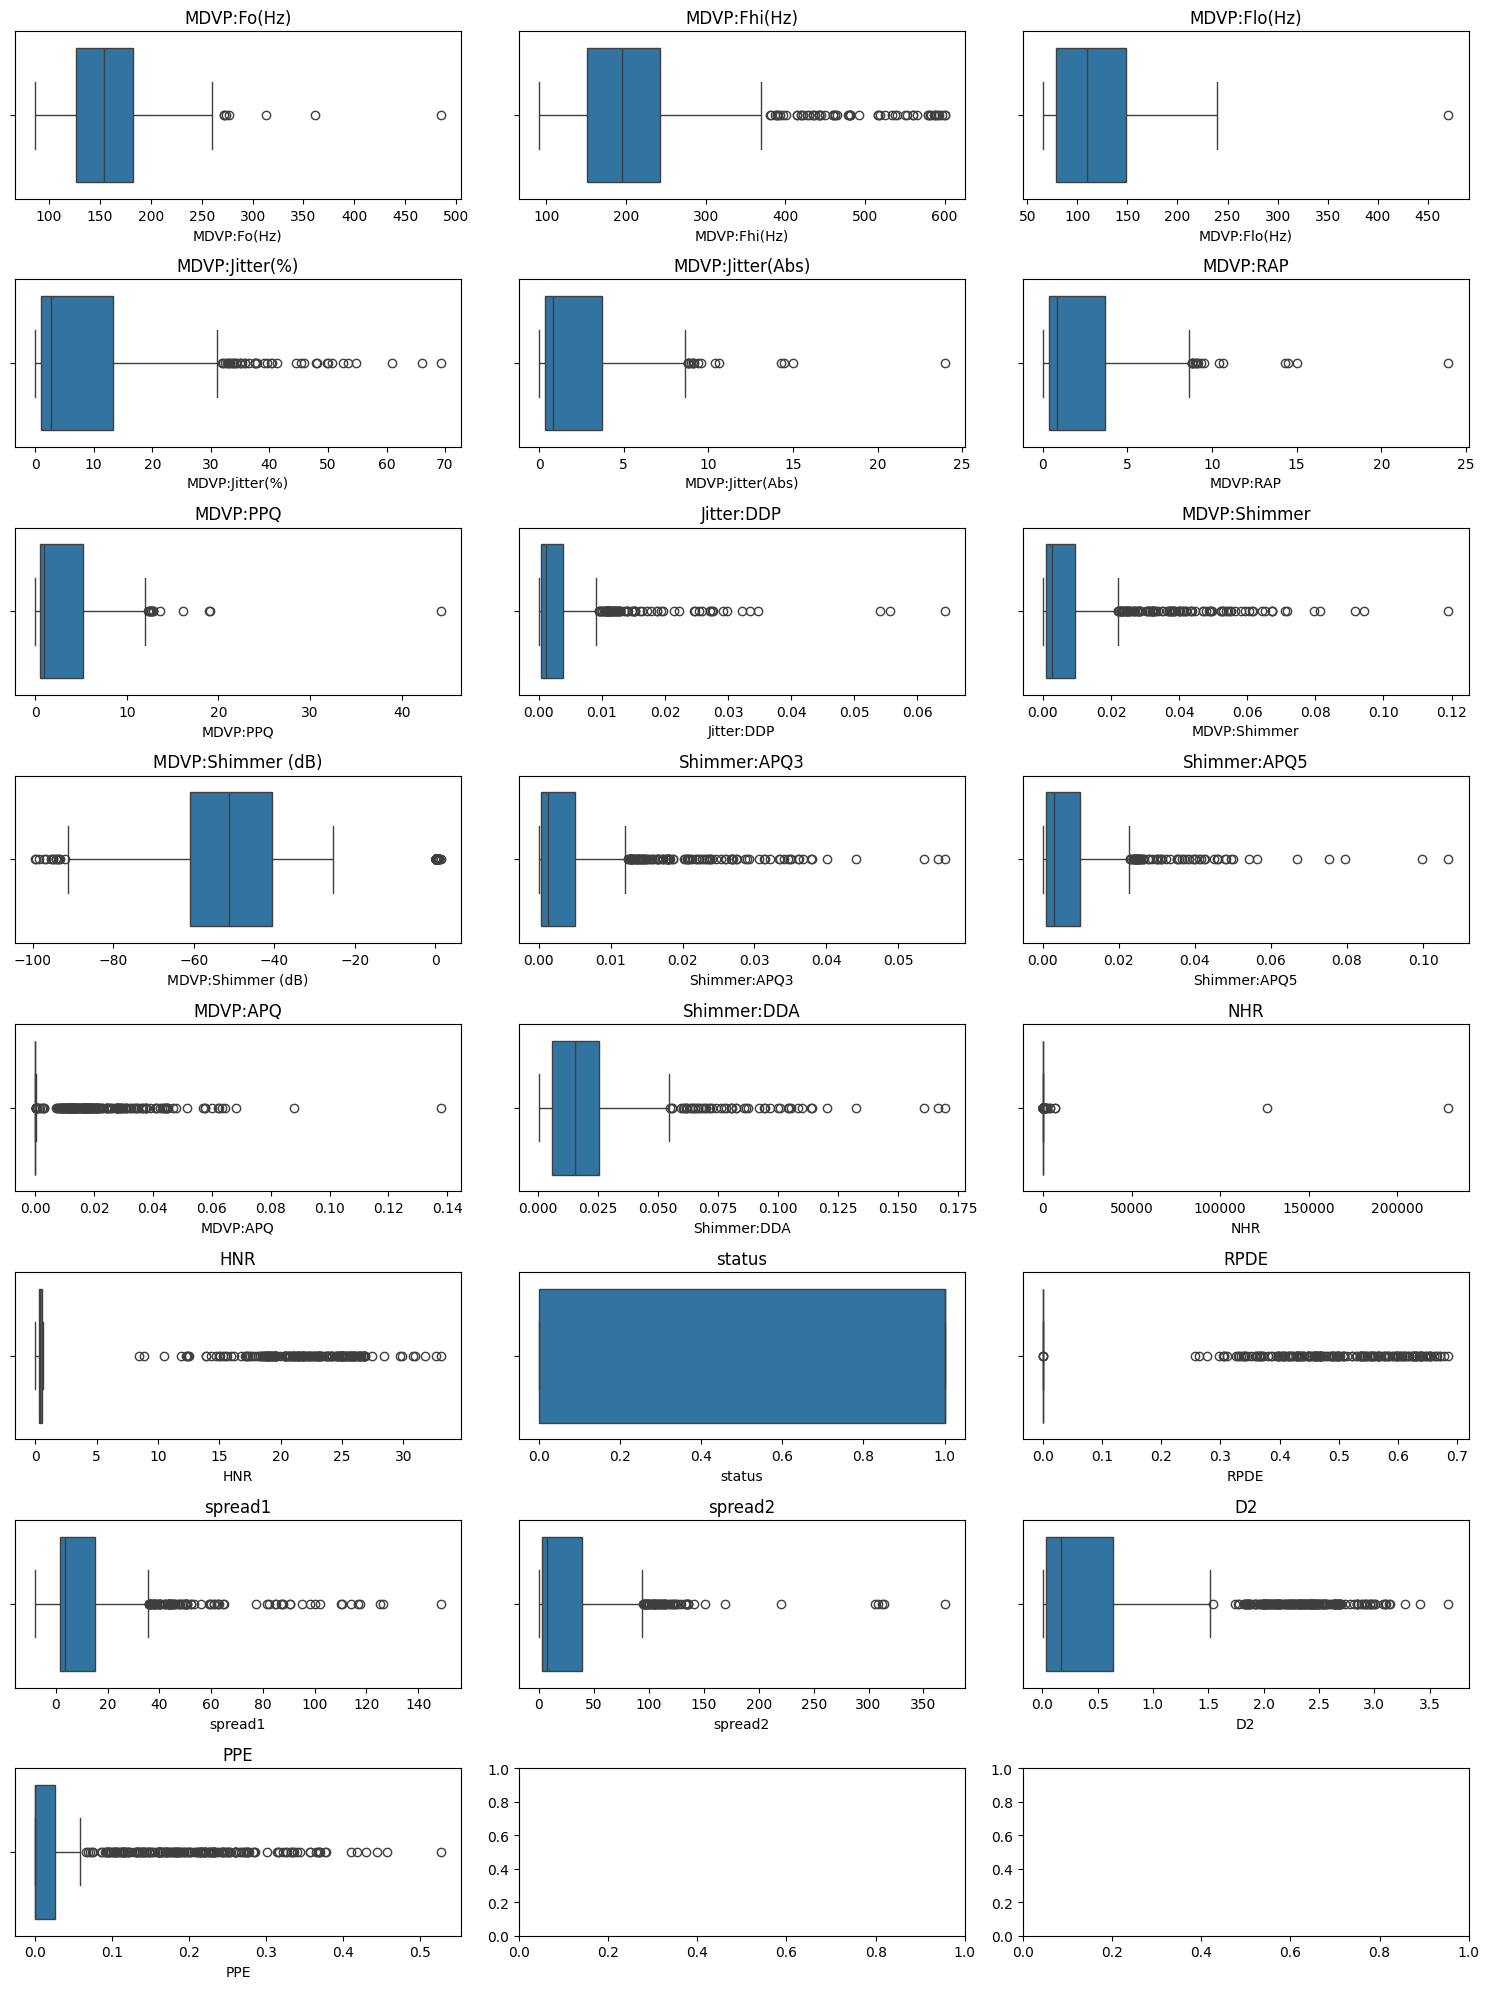

Indices of outliers:
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       940, 941, 943, 944, 945, 946, 950, 955, 956, 957],
      dtype='int64', length=437)


In [17]:
# Check for outliers

import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of numerical columns
num_cols = len([col for col in data.columns if data[col].dtype != 'object'])

# Set up subplots for box plots
fig, axs = plt.subplots(nrows=(num_cols + 2) // 3, ncols=3, figsize=(15, 20))

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Loop through each numerical feature and plot box plot
for i, column in enumerate(data.columns):
    if data[column].dtype != 'object':  # Check if the column is numerical
        sns.boxplot(x=data[column], ax=axs[i], orient='h')
        axs[i].set_title(f'{column}')

plt.tight_layout()
plt.show()

# Statistical method using IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = ((data < lower_bound) | (data > upper_bound)).any(axis=1)
print("Indices of outliers:")
print(outliers[outliers].index)


In [18]:
# Dependent variable
y = data['status']

# Independent variables
X = data.drop(columns=['status'])

#features and target variable


Correlation Matrix:


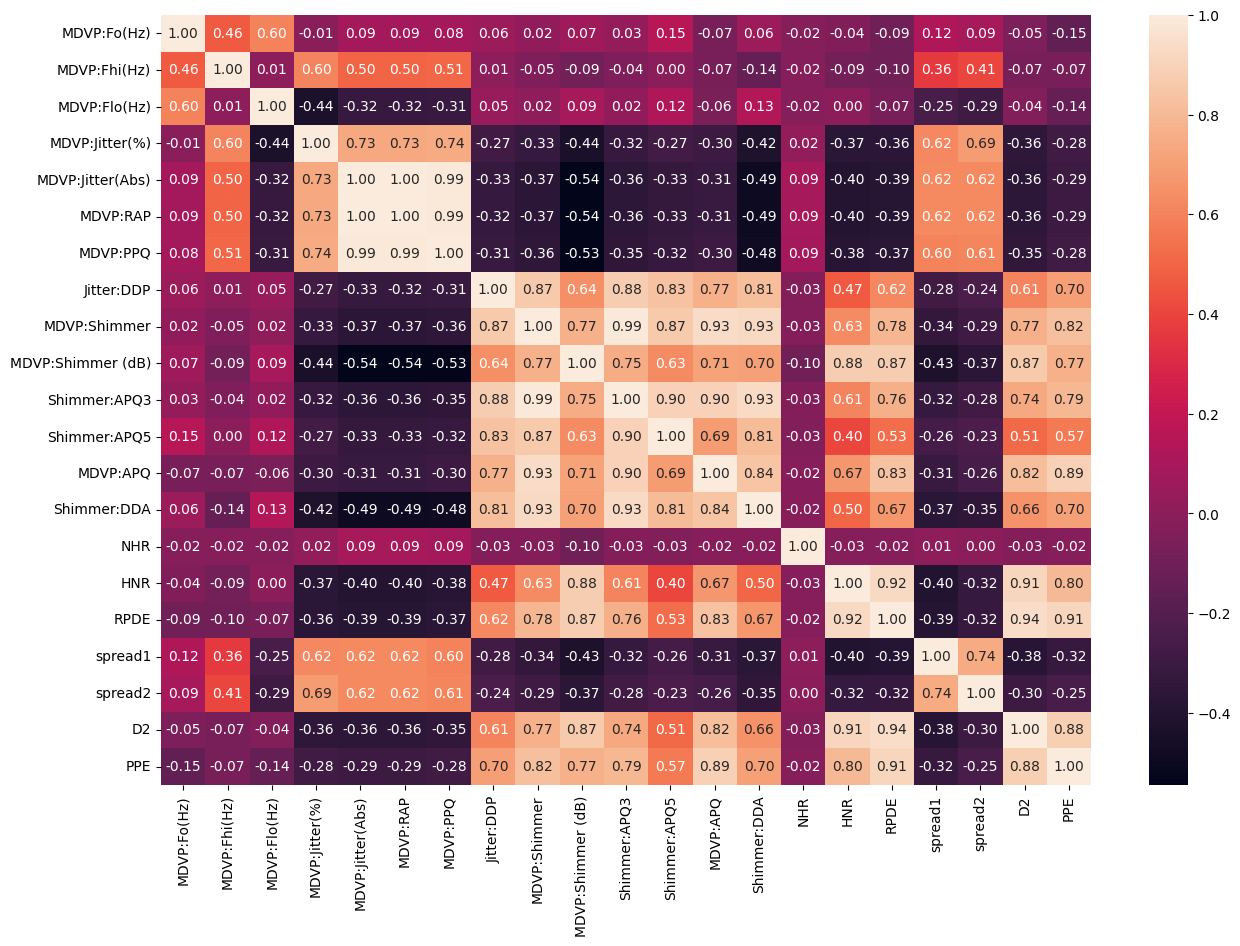

In [20]:
# Analyze Features (optional)
# Correlation Matrix
correlation_matrix = X.corr()
print("Correlation Matrix:")
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

In [21]:
# Normalization/Standardization (optional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

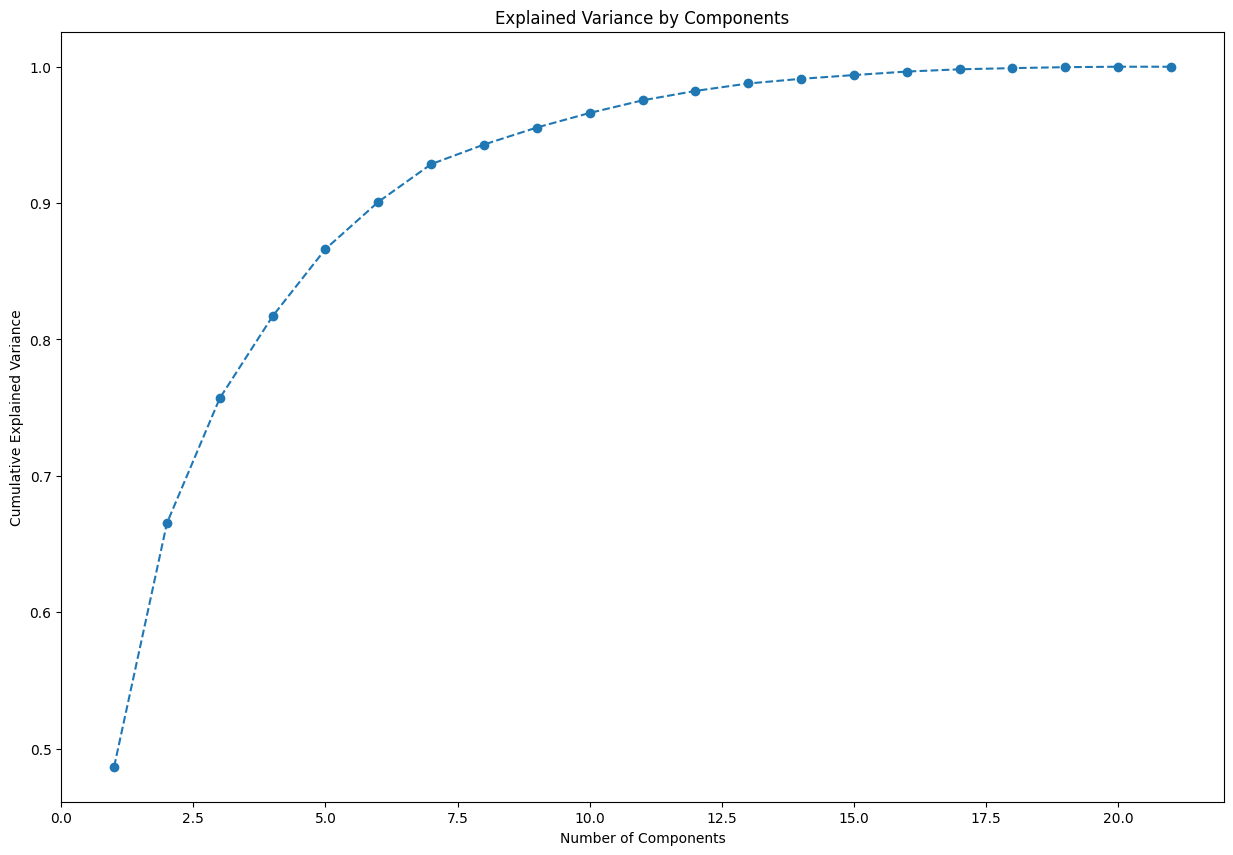

In [29]:
# PCA (optional)
pca = PCA(n_components=0.99999999999999) # Retain 100% variance
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 10))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [36]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [37]:
# Data Augmentation - SMOTE
smote = SMOTE(sampling_strategy=0.5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Model Training & Evaluation
#### Repeat for each algorithm:

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Model Training
rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred = rf.predict(X_test)
print("Random Forest Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Evaluation:
[[ 92  33]
 [ 36 133]]
              precision    recall  f1-score   support

         0.0       0.72      0.74      0.73       125
         1.0       0.80      0.79      0.79       169

    accuracy                           0.77       294
   macro avg       0.76      0.76      0.76       294
weighted avg       0.77      0.77      0.77       294



## LightGBM

In [51]:
import lightgbm as lgb
import warnings

# Define the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(verbose=-1)

# Train the LightGBM classifier
lgb_classifier.fit(X_train, y_train)

# Model Evaluation
y_pred_lgb = lgb_classifier.predict(X_test)
warnings.simplefilter(action='ignore', category=UserWarning)
print("LightGBM Evaluation:")
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))


LightGBM Evaluation:
[[ 87  38]
 [ 28 141]]
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.72       125
         1.0       0.79      0.83      0.81       169

    accuracy                           0.78       294
   macro avg       0.77      0.77      0.77       294
weighted avg       0.77      0.78      0.77       294



## XGBoost

In [48]:
import xgboost as xgb

# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Train the XGBoost classifier
xgb_classifier.fit(X_train, y_train)

# Model Evaluation
y_pred_xgb = xgb_classifier.predict(X_test)
print("XGBoost Evaluation:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Evaluation:
[[ 84  41]
 [ 28 141]]
              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71       125
         1.0       0.77      0.83      0.80       169

    accuracy                           0.77       294
   macro avg       0.76      0.75      0.76       294
weighted avg       0.76      0.77      0.76       294



## CatBoost

In [53]:
from catboost import CatBoostClassifier

# Define the CatBoost classifier
catboost_classifier = CatBoostClassifier(verbose=0)

# Train the CatBoost classifier
catboost_classifier.fit(X_train, y_train)

# Model Evaluation
y_pred_catboost = catboost_classifier.predict(X_test)
print("CatBoost Evaluation:")
print(confusion_matrix(y_test, y_pred_catboost))
print(classification_report(y_test, y_pred_catboost))

CatBoost Evaluation:
[[ 86  39]
 [ 26 143]]
              precision    recall  f1-score   support

         0.0       0.77      0.69      0.73       125
         1.0       0.79      0.85      0.81       169

    accuracy                           0.78       294
   macro avg       0.78      0.77      0.77       294
weighted avg       0.78      0.78      0.78       294



## SVM

In [39]:
from sklearn.svm import SVC

# Model Training
svm = SVC()
svm.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred = svm.predict(X_test)
print("SVM Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


SVM Evaluation:
[[107  18]
 [ 61 108]]
              precision    recall  f1-score   support

         0.0       0.64      0.86      0.73       125
         1.0       0.86      0.64      0.73       169

    accuracy                           0.73       294
   macro avg       0.75      0.75      0.73       294
weighted avg       0.76      0.73      0.73       294



## KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

# Model Training
knn = KNeighborsClassifier()
knn.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred = knn.predict(X_test)
print("KNN Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

KNN Evaluation:
[[102  23]
 [ 57 112]]
              precision    recall  f1-score   support

         0.0       0.64      0.82      0.72       125
         1.0       0.83      0.66      0.74       169

    accuracy                           0.73       294
   macro avg       0.74      0.74      0.73       294
weighted avg       0.75      0.73      0.73       294



## Extra Trees


In [41]:
from sklearn.ensemble import ExtraTreesClassifier

# Model Training
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred = extra_trees.predict(X_test)
print("Extra Trees Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Extra Trees Evaluation:
[[ 90  35]
 [ 37 132]]
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71       125
         1.0       0.79      0.78      0.79       169

    accuracy                           0.76       294
   macro avg       0.75      0.75      0.75       294
weighted avg       0.76      0.76      0.76       294



## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

# Model Training
log_reg = LogisticRegression()
log_reg.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred = log_reg.predict(X_test)
print("Logistic Regression Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Evaluation:
[[104  21]
 [ 57 112]]
              precision    recall  f1-score   support

         0.0       0.65      0.83      0.73       125
         1.0       0.84      0.66      0.74       169

    accuracy                           0.73       294
   macro avg       0.74      0.75      0.73       294
weighted avg       0.76      0.73      0.74       294



# 4. Model Validation

In [54]:
from sklearn.model_selection import cross_val_score

# Define a function for cross-validation
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    print("Cross-Validation Scores:", scores)
    print("Mean Accuracy:", scores.mean())

# Perform cross-validation for each model
print("\nRandom Forest Cross-Validation:")
evaluate_model(rf, X_train_resampled, y_train_resampled)

print("\nLightGBM Cross-Validation:")
evaluate_model(lgb_classifier, X_train_resampled, y_train_resampled)

print("\nXGBoost Cross-Validation:")
evaluate_model(xgb_classifier, X_train_resampled, y_train_resampled)

print("\nCatBoost Cross-Validation:")
evaluate_model(catboost_classifier, X_train_resampled, y_train_resampled)

print("\nSVM Cross-Validation:")
evaluate_model(svm, X_train_resampled, y_train_resampled)

print("\nKNN Cross-Validation:")
evaluate_model(knn, X_train_resampled, y_train_resampled)

print("\nExtra Trees Cross-Validation:")
evaluate_model(extra_trees, X_train_resampled, y_train_resampled)

print("\nLogistic Regression Cross-Validation:")
evaluate_model(log_reg, X_train_resampled, y_train_resampled)


Random Forest Cross-Validation:
Cross-Validation Scores: [0.77108434 0.86746988 0.86746988 0.77108434 0.87804878 0.85365854
 0.85365854 0.92682927 0.8902439  0.85365854]
Mean Accuracy: 0.8533205994710549

LightGBM Cross-Validation:
Cross-Validation Scores: [0.77108434 0.85542169 0.89156627 0.79518072 0.85365854 0.8902439
 0.84146341 0.91463415 0.91463415 0.91463415]
Mean Accuracy: 0.8642521304731121

XGBoost Cross-Validation:
Cross-Validation Scores: [0.81927711 0.84337349 0.84337349 0.81927711 0.8902439  0.82926829
 0.79268293 0.90243902 0.8902439  0.93902439]
Mean Accuracy: 0.8569203643843668

CatBoost Cross-Validation:
Cross-Validation Scores: [0.81927711 0.87951807 0.89156627 0.81927711 0.8902439  0.8902439
 0.84146341 0.93902439 0.87804878 0.92682927]
Mean Accuracy: 0.8775492212753452

SVM Cross-Validation:
Cross-Validation Scores: [0.73493976 0.74698795 0.78313253 0.69879518 0.75609756 0.80487805
 0.73170732 0.7195122  0.79268293 0.76829268]
Mean Accuracy: 0.7537026153394064

KN

# 5. Ensembling Methods


## Stacking

Stacking Classifier Evaluation:


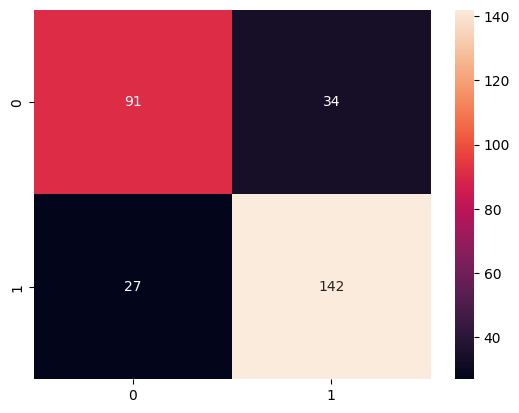

              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75       125
         1.0       0.81      0.84      0.82       169

    accuracy                           0.79       294
   macro avg       0.79      0.78      0.79       294
weighted avg       0.79      0.79      0.79       294



In [58]:
from sklearn.ensemble import StackingClassifier

# Define estimators for stacking
estimators = [
    ('rf', rf),
    ('xgb', xgb_classifier),
    ('lgb', lgb_classifier),
    ('catboost', catboost_classifier),
    ('svm', svm),
    ('knn', knn),
    ('extra_trees', extra_trees),
    ('log_reg', log_reg)
]

# Define the stacking classifier
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Train the stacking classifier
stacking_classifier.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred = stacking_classifier.predict(X_test)
print("Stacking Classifier Evaluation:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()
print(classification_report(y_test, y_pred))

## Bagging

Bagging Classifier Evaluation:


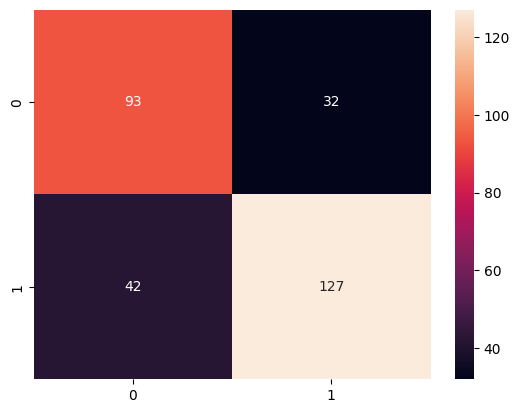

              precision    recall  f1-score   support

         0.0       0.69      0.74      0.72       125
         1.0       0.80      0.75      0.77       169

    accuracy                           0.75       294
   macro avg       0.74      0.75      0.74       294
weighted avg       0.75      0.75      0.75       294



In [60]:
from sklearn.ensemble import BaggingClassifier

# Define base estimator
base_estimator = RandomForestClassifier()

# Define the bagging classifier
bagging_classifier = BaggingClassifier(estimator=base_estimator, n_estimators=10)

# Train the bagging classifier
bagging_classifier.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred = bagging_classifier.predict(X_test)
print("Bagging Classifier Evaluation:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()
print(classification_report(y_test, y_pred))

## Boosting (AdaBoost)


AdaBoost Classifier Evaluation:


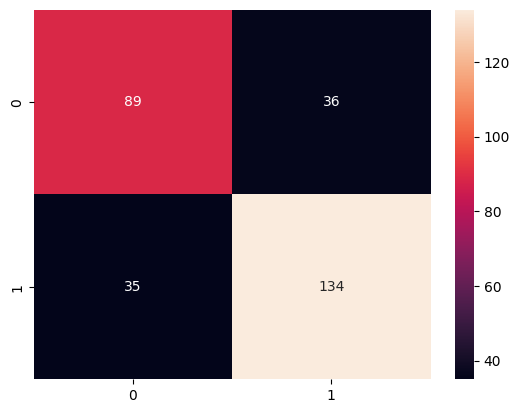

              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71       125
         1.0       0.79      0.79      0.79       169

    accuracy                           0.76       294
   macro avg       0.75      0.75      0.75       294
weighted avg       0.76      0.76      0.76       294



In [61]:
from sklearn.ensemble import AdaBoostClassifier

# Define base estimator
base_estimator = RandomForestClassifier()

# Define the AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(estimator=base_estimator, n_estimators=50)

# Train the AdaBoost classifier
adaboost_classifier.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred = adaboost_classifier.predict(X_test)
print("AdaBoost Classifier Evaluation:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()
print(classification_report(y_test, y_pred))

## Voting

Voting Classifier Evaluation:


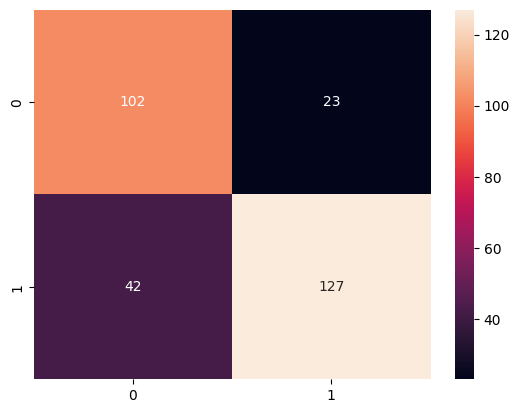

              precision    recall  f1-score   support

         0.0       0.71      0.82      0.76       125
         1.0       0.85      0.75      0.80       169

    accuracy                           0.78       294
   macro avg       0.78      0.78      0.78       294
weighted avg       0.79      0.78      0.78       294



In [63]:
from sklearn.ensemble import VotingClassifier

# Define the voting classifier
voting_classifier = VotingClassifier(estimators=estimators, voting='hard')

# Train the voting classifier
voting_classifier.fit(X_train_resampled, y_train_resampled)

# Model Evaluation
y_pred = voting_classifier.predict(X_test)
print("Voting Classifier Evaluation:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()
print(classification_report(y_test, y_pred))


# 6. Observe the Results

## 1. Confusion Matrix


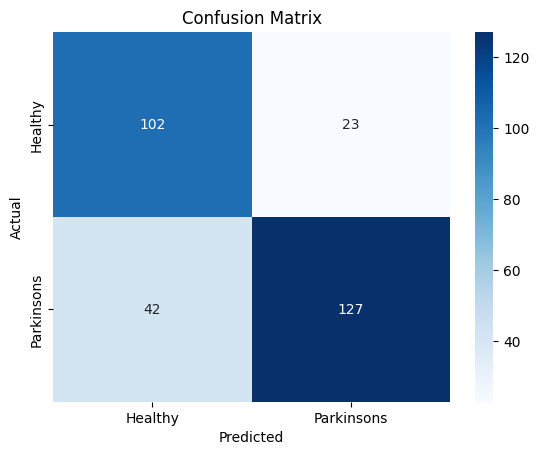

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Healthy', 'Parkinsons'], yticklabels=['Healthy', 'Parkinsons'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

## 2. ROC Curve

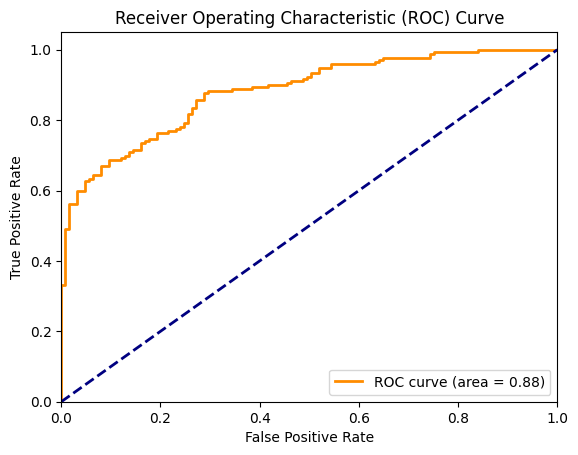

In [65]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

y_pred_prob = stacking_classifier.predict_proba(X_test)[:, 1]  # Use predict_proba for classifiers supporting it
plot_roc_curve(y_test, y_pred_prob)


## 3. Classification Report


In [66]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

print_classification_report(y_test, y_pred)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.82      0.76       125
         1.0       0.85      0.75      0.80       169

    accuracy                           0.78       294
   macro avg       0.78      0.78      0.78       294
weighted avg       0.79      0.78      0.78       294



## 4. Model Comparison

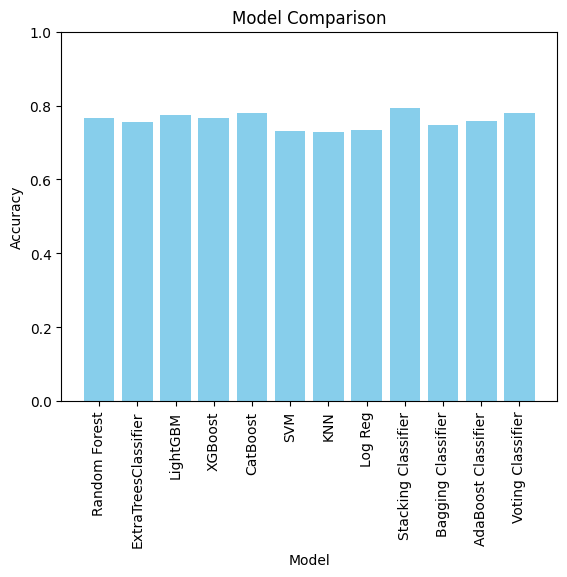

In [69]:
from sklearn.metrics import accuracy_score

# Example comparing accuracy
models = ['Random Forest', 'ExtraTreesClassifier', 'LightGBM', 'XGBoost', 'CatBoost', 'SVM', 'KNN', 'Log Reg', 'Stacking Classifier', 'Bagging Classifier', 'AdaBoost Classifier', 'Voting Classifier']
accuracies = [accuracy_score(y_test, rf.predict(X_test)),
              accuracy_score(y_test, extra_trees.predict(X_test)),
                accuracy_score(y_test, lgb_classifier.predict(X_test)),
                accuracy_score(y_test, xgb_classifier.predict(X_test)),
                accuracy_score(y_test, catboost_classifier.predict(X_test)),
                accuracy_score(y_test, svm.predict(X_test)),
                accuracy_score(y_test, knn.predict(X_test)),
                accuracy_score(y_test, log_reg.predict(X_test)),
              accuracy_score(y_test, stacking_classifier.predict(X_test)),
              accuracy_score(y_test, bagging_classifier.predict(X_test)),
              accuracy_score(y_test, adaboost_classifier.predict(X_test)),
              accuracy_score(y_test, voting_classifier.predict(X_test))]

plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.xticks(rotation=90)
plt.show()


# Additional Metrics


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# # Define the classifiers
# classifiers = {
#     'Random Forest': RandomForestClassifier(random_state=7),
#     'Extra Trees': ExtraTreesClassifier(random_state=7),
#     'LightGBM': LGBMClassifier(random_state=7),
#     'XGBoost': XGBClassifier(random_state=7),
#     'CatBoost': CatBoostClassifier(random_state=7, verbose=0),
#     'SVM': SVC(random_state=7),
#     'Logistic Regression': LogisticRegression(random_state=7),
#     'KNN': KNeighborsClassifier(),
#     'Stacking': StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=7)), ('lr', LogisticRegression(random_state=7))], final_estimator=LogisticRegression(), cv=5),
#     'Bagging': BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=7),
#     'AdaBoost': AdaBoostClassifier(random_state=7),
#     'Voting': VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=7)), ('lr', LogisticRegression(random_state=7)), ('xgb', XGBClassifier(random_state=7))], voting='hard')
# }


classifiers = [rf, extra_trees, lgb_classifier, xgb_classifier, catboost_classifier, svm, log_reg, knn, stacking_classifier, bagging_classifier, adaboost_classifier, voting_classifier]

# train the model
for clf in classifiers:
    clf.fit(X_train, y_train)
    print(f"{clf} has been trained successfully.")

In [73]:
# Additional Metrics
def print_additional_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"\n Metrics for {model.__class__.__name__}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("------------------------")

for model in [rf, extra_trees, lgb_classifier, xgb_classifier, catboost_classifier, svm, log_reg, knn, stacking_classifier, bagging_classifier, adaboost_classifier, voting_classifier]:
    print_additional_metrics(model, X_test, y_test)


 Metrics for RandomForestClassifier:
Precision: 0.7776679841897234
Recall: 0.7660355029585799
F1-score: 0.7696341389910193
------------------------

 Metrics for ExtraTreesClassifier:
Precision: 0.7799833765217816
Recall: 0.771076923076923
F1-score: 0.7741176470588236
------------------------

 Metrics for LGBMClassifier:
Precision: 0.7721156181685693
Recall: 0.7651597633136095
F1-score: 0.7676724137931035
------------------------

 Metrics for XGBClassifier:
Precision: 0.7623626373626373
Recall: 0.7531597633136096
F1-score: 0.7561397814562372
------------------------

 Metrics for CatBoostClassifier:
Precision: 0.7767857142857143
Recall: 0.767076923076923
F1-score: 0.7702766057196437
------------------------

 Metrics for SVC:
Precision: 0.7314708381228447
Recall: 0.7192426035502959
F1-score: 0.7223459899263851
------------------------

 Metrics for LogisticRegression:
Precision: 0.7074142156862745
Recall: 0.692284023668639
F1-score: 0.6950467985405201
------------------------

 Metr

In [74]:
def error_analysis(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = X_test[y_test != y_pred]
    error_labels = y_test[y_test != y_pred]
    predicted_labels = y_pred[y_test != y_pred]
    # Perform analysis on errors, e.g., visualize spectrograms, inspect features, etc.
    print(f"Error analysis for {model.__class__.__name__}:")
    print("Number of errors:", len(errors))
    print("------------------------")

for model in [rf, extra_trees, lgb_classifier, xgb_classifier, catboost_classifier, svm, log_reg, knn, stacking_classifier, bagging_classifier, adaboost_classifier, voting_classifier]:
    error_analysis(model, X_test, y_test)

Error analysis for RandomForestClassifier:
Number of errors: 65
------------------------
Error analysis for ExtraTreesClassifier:
Number of errors: 64
------------------------
Error analysis for LGBMClassifier:
Number of errors: 66
------------------------
Error analysis for XGBClassifier:
Number of errors: 69
------------------------
Error analysis for CatBoostClassifier:
Number of errors: 65
------------------------
Error analysis for SVC:
Number of errors: 78
------------------------
Error analysis for LogisticRegression:
Number of errors: 85
------------------------
Error analysis for KNeighborsClassifier:
Number of errors: 78
------------------------
Error analysis for StackingClassifier:
Number of errors: 65
------------------------
Error analysis for BaggingClassifier:
Number of errors: 73
------------------------
Error analysis for AdaBoostClassifier:
Number of errors: 66
------------------------
Error analysis for VotingClassifier:
Number of errors: 68
------------------------

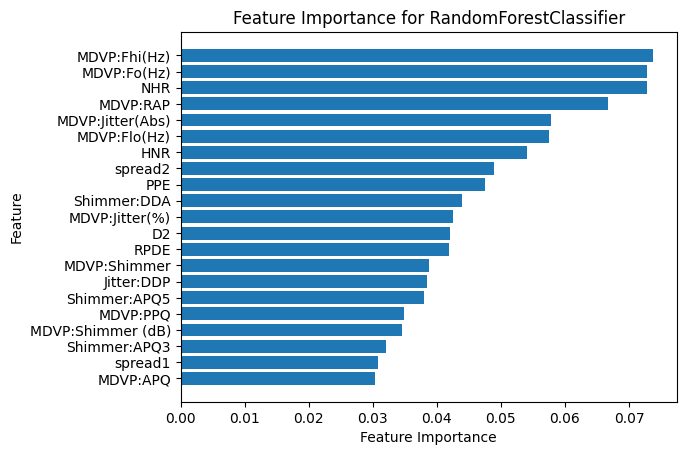

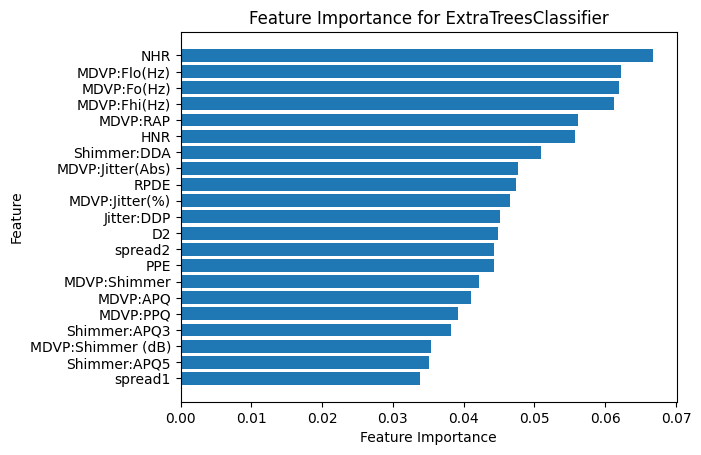

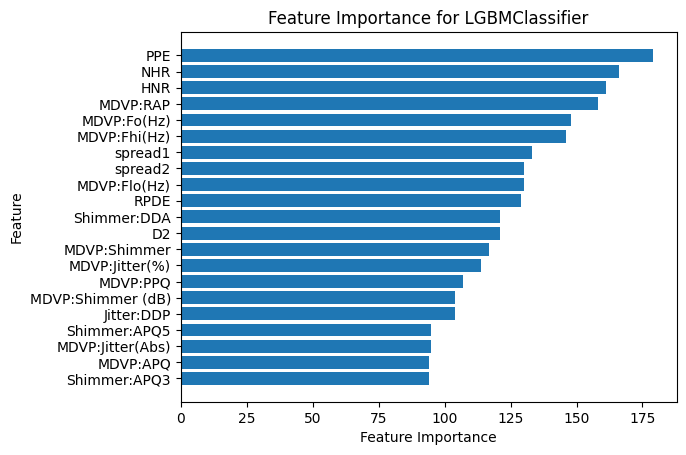

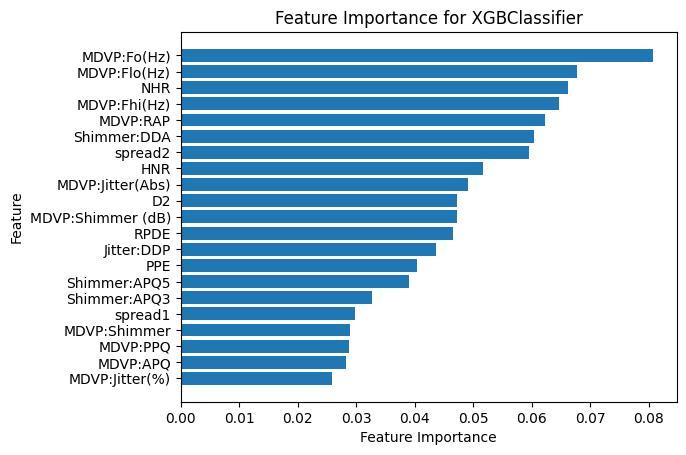

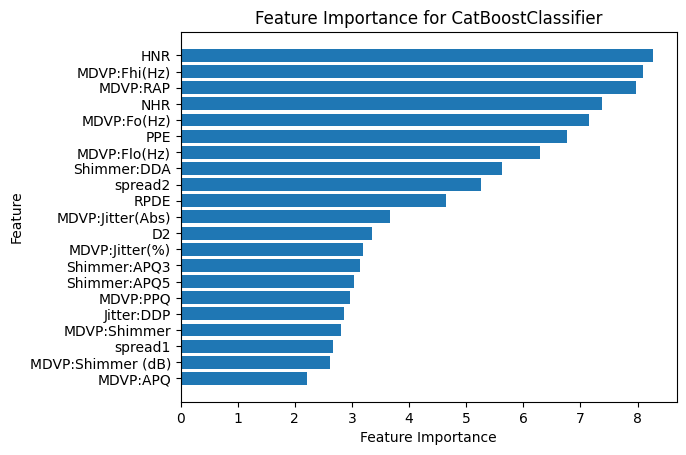

SVC doesn't support feature importance
LogisticRegression doesn't support feature importance
KNeighborsClassifier doesn't support feature importance
StackingClassifier doesn't support feature importance
BaggingClassifier doesn't support feature importance


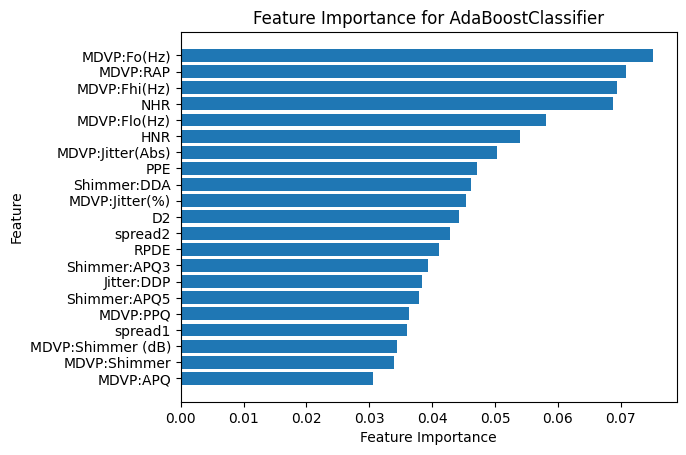

VotingClassifier doesn't support feature importance


In [77]:
def plot_feature_importance(model, feature_names):
    try:
        # For models that have feature_importances_ attribute
        feature_importance = model.feature_importances_
    except AttributeError:
        try:
            # For XGBoost models
            feature_importance = model.get_fscore()
        except:
            print(f"{model.__class__.__name__} doesn't support feature importance")
            return

    sorted_idx = np.argsort(feature_importance)
    plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance for " + model.__class__.__name__)
    plt.show()

for model in [rf, extra_trees, lgb_classifier, xgb_classifier, catboost_classifier, svm, log_reg, knn, stacking_classifier, bagging_classifier, adaboost_classifier, voting_classifier]:
    plot_feature_importance(model, X.columns)